# LATW Challenge Problem: Mini global fit

In this challenge problem, you will combine what you have learned from the tutorials to build a miniature global fit pipeline. We will combine 1 MBHB with ~8 Galactic binaries. The Galactic binaries will be split in two groups with the groups separated in frequency so they are non-interacting. The goal is to fit for the MBHB and for the GBs while characterizing the uncertainty in the GB model count and parameters. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lisatools.utils.constants import *
from copy import deepcopy  # can be useful
from lisatools.utils.constants import *

## Generate the data

In [2]:
# waveform setup
from bbhx.waveformbuild import BBHWaveformFD
from lisatools.sensitivity import get_sensitivity, AE1SensitivityMatrix
from gbgpu.gbgpu import GBGPU
gb = GBGPU()
tdi_wave_gen = BBHWaveformFD()

No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


### MBHB injection parameters and waveform 

In [3]:
# mbh injection parameters
m1 = 2e6
m2 = 7e5
chi1 = 0.5
chi2 = 0.7
dist = 15 * 1e9 * PC_SI
phi_ref = 0.6
f_ref = 0.0
inc = np.pi / 8
lam = 3.4
beta = -0.7
psi = np.pi/4
t_ref = 1e6 # seconds

length = 1024

# setup data holders
Tobs = YRSID_SI / 4  # 3 month
dt = 10.0  # sec
N = int(Tobs / dt)
Tobs = N * dt

freqs = np.fft.rfftfreq(N, dt)
df = freqs[1] - freqs[0]
AET = tdi_wave_gen(
    m1,
    m2, 
    chi1,
    chi2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref,
    length=1024, 
    combine=False,  # TODO: check this
    direct=False,
    fill=True,
    squeeze=True,
    freqs=freqs
)

### GBs parameters and waveforms

In [4]:
injection_binaries = np.asarray([
    [8.232131e-22, 0.0040004234, 1.5e-17, 0.0, 1.34248932, 3.0121342, 0.8923484, 0.034323, 1.023234],
    [7.823497204e-22, 0.00400087123489, 0.1e-17, 0.0, 3.47234293, 2.787263432, 1.2349823, 3.093492342, 0.9323423],
    [9.234809e-22, 0.004000923048231, 0.9e-17, 0.0, 0.2312012, 0.23423874, 3.11212101, 4.230948234, 0.012312],
    [2.93209832e-22, 0.00500324293432, 3e-17, 0.0, 0.7459203, 0.485720246, 0.99998523423, 2.958929324, -0.3243432],
    [3.9723498273e-22, 0.005002349823742, 2e-17, 0.0, 4.23498234, 1.823487234, 0.12987545, 2.01238923, -0.92342234],
    [1.87234e-22, 0.00500823423, 4e-17, 0.0, 5.8303875067, 2.1823432, 2.98523943, 3.0324923, -0.34598345],
    [8.2039823423e-22, 0.0050094359834, 5e-17, 0.0, 4.23498734, 1.3340398, 1.9283423, 3.3402934823, 0.6535098324],
])

gb.run_wave(*injection_binaries.T, N=128, T=Tobs, dt=dt)
Agb = gb.A.copy()
Egb = gb.E.copy()
start_inds = gb.start_inds.copy()

/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:83: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:85: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:87: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:92: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:94: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d * (2.0

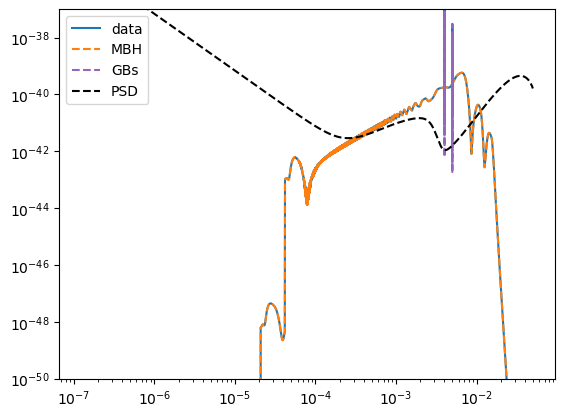

In [8]:
sens_mat = AE1SensitivityMatrix(freqs, model="sangria", stochastic_params=(YRSID_SI,))

data = [np.zeros_like(freqs, dtype=complex), np.zeros_like(freqs, dtype=complex)]
data[0] += AET[0, 0]
data[1] += AET[0, 1]
for i in range(Agb.shape[0]):
    start_ind = start_inds[i]
    A = Agb[i]
    E = Egb[i]

    data[0][start_ind: start_ind + Agb.shape[1]] += A
    data[1][start_ind: start_ind + Agb.shape[1]] += E

plt.loglog(freqs, np.abs(data[0]) ** 2 * 2 * df, label="data")
plt.loglog(freqs, np.abs(AET[0, 0]) ** 2 * 2 * df, ls='--', label="MBH")

for i in range(Agb.shape[0]):
    start_ind = start_inds[i]
    A = Agb[i]
    lab = "GBs" if i == 0 else None
    plt.loglog(freqs[start_ind: start_ind + Agb.shape[1]], np.abs(A) ** 2 * 2 * df, c="C4", ls='--', label=lab)

plt.loglog(freqs, sens_mat.sens_mat[0], c='k', ls='--', label="PSD")
# plt.xlim(3.99e-3,4.01e-3)
plt.ylim(1e-50, 1e-37)
plt.legend()

## A Mini Global Fit

Now you will build up a global fit pipeline to fit that data. There are many, many ways to do this. The answer key provided is just one of them. 

Some hints:

* Likelihood: I recommend building an initial Likelihood function that concentrates on gettings the computation right rather than speed. Once, it works, you can run it longer or improve the bottleneck later on. 
* Remember to implement an in-model proposal for the GBs because the stretch proposal will not work.
* I recommend using fixed-dimensional sampling on the MBHB. Use the regular stretch move for this.
* You will have to decide how to deal with the two different groups of GBs. I recommend using two separate models or "branches" in the sampler with different priors. Their priors would differ in their frequency and frequency derivative.
* I recommend using the `eryn.utils.TransformContainer` and the `eryn.utils.PeriodicContainer`.
* Look at Tutorials 4 and 6 for inspiration. 
  